In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
# CIFAR-10 dataset
from tensorflow.keras.datasets import cifar10
# ResNet50 Transfer Learning
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


The CIFAR-10 consists of 60000 32x32 colour images.

This data offers 10 classes for classification, with 6000 images per class.

There are 50000 training images and 10000 test images.
Here are the classes in the dataset, as well as 10 random images from each:

In [ ]:
train_images.shape, train_labels.shape

((50000, 32, 32, 3), (50000, 1))

In [ ]:
# Data Checkout
print ("The number of training examples is: ", train_images.shape[0])
print ("The number of test examples is: ", test_images.shape[0])
print ("The size of every img is: ", train_images.shape[1:])
num_classes=len(np.unique(train_labels))
print ("The number of classes is: ", num_classes)

The number of training examples is:  50000
The number of test examples is:  10000
The size of every img is:  (32, 32, 3)
The number of classes is:  10


10 classes, with 6,000 images per class.

The classes are:

Airplane

Automobile

Bird

Cat

Deer

Dog

Frog

Horse

Ship

Truck

In [ ]:
# Display class names for reference
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
print(f"\nCIFAR-10 Classes: {class_names}")


CIFAR-10 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Getting a subset of 10k from the training data
n = 10000

train_images = train_images[:n]
train_labels = train_labels[:n]

print(f"Selected training images shape: {train_images.shape}")
print(f"Selected training labels shape: {train_labels.shape}")

Selected training images shape: (10000, 32, 32, 3)
Selected training labels shape: (10000, 1)


In [ ]:
# Looking at the train labels structure
print("\nFirst 10 labels:")
print(train_labels[:10])

# Checking the shape
print(f"\nLabels shape: {train_labels.shape}")


First 10 labels:
[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

Labels shape: (10000, 1)


In [ ]:
# Getting a single array of labels (flatten from 2D to 1D)
flattened_labels = train_labels.flatten()
print(f"Flattened labels shape: {flattened_labels.shape}")
print(f"First 10 flattened labels: {flattened_labels[:10]}")

Flattened labels shape: (10000,)
First 10 flattened labels: [6 9 9 4 1 1 2 7 8 3]



Label distribution:
0    1005
1     974
2    1032
3    1016
4     999
5     937
6    1030
7    1001
8    1025
9     981
Name: count, dtype: int64


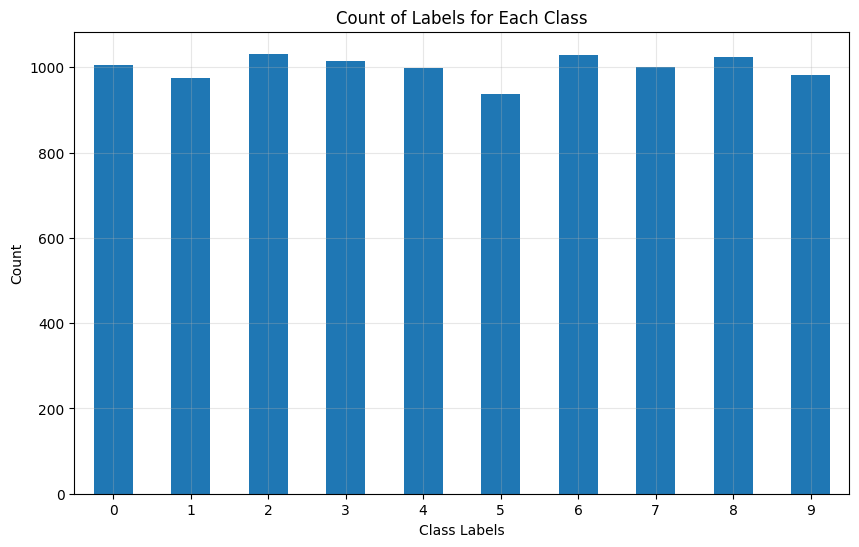

In [ ]:
# Analyzing label distribution
print("\nLabel distribution:")
label_counts = pd.Series(flattened_labels).value_counts().sort_index()
print(label_counts)

# Plot label distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Count of Labels for Each Class')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Define class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# Display individual images with labels
def plot_image(i, show_title=True):
    """Plot a single image with its class label"""
    image = train_images[i]
    label = train_labels.flatten()[i]
    class_name = classes[label]

    plt.imshow(image)
    if show_title:
        plt.title(f'Class: {class_name} (Label: {label})')
    plt.axis('off')
    return class_name


INDIVIDUAL IMAGE EXAMPLES


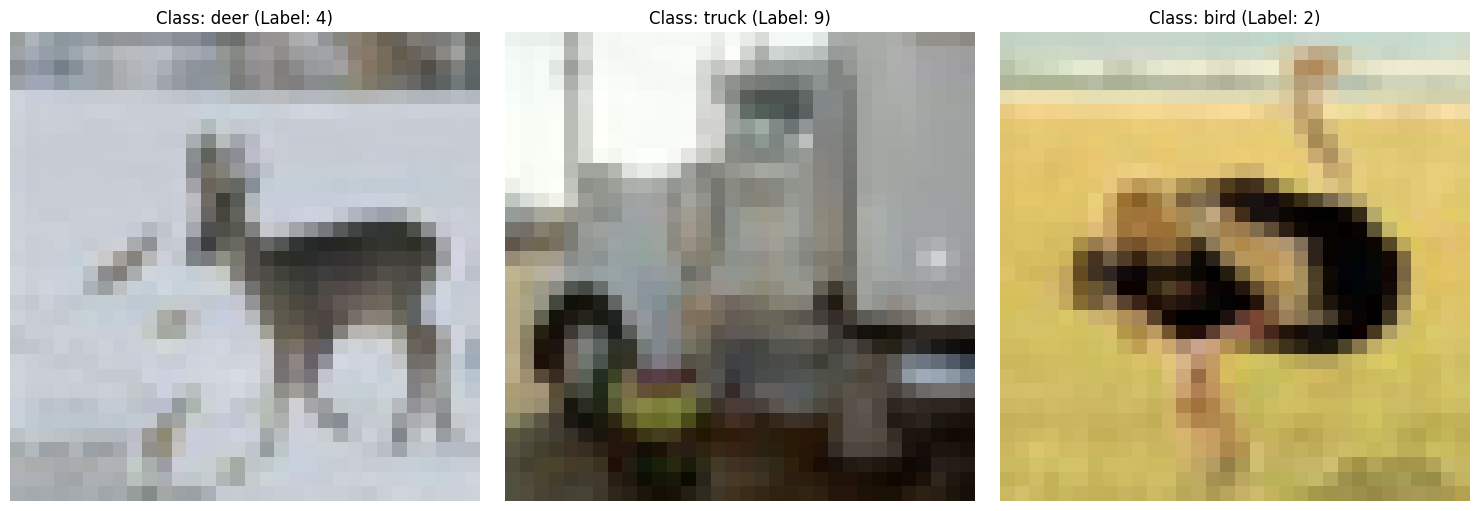

In [ ]:
# Example 1: Display image at index 20
print("\n" + "="*40)
print("INDIVIDUAL IMAGE EXAMPLES")
print("="*40)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_image(20)

plt.subplot(1, 3, 2)
plot_image(31)

plt.subplot(1, 3, 3)
plot_image(1077)

plt.tight_layout()
plt.show()



RANDOM SAMPLE GRID


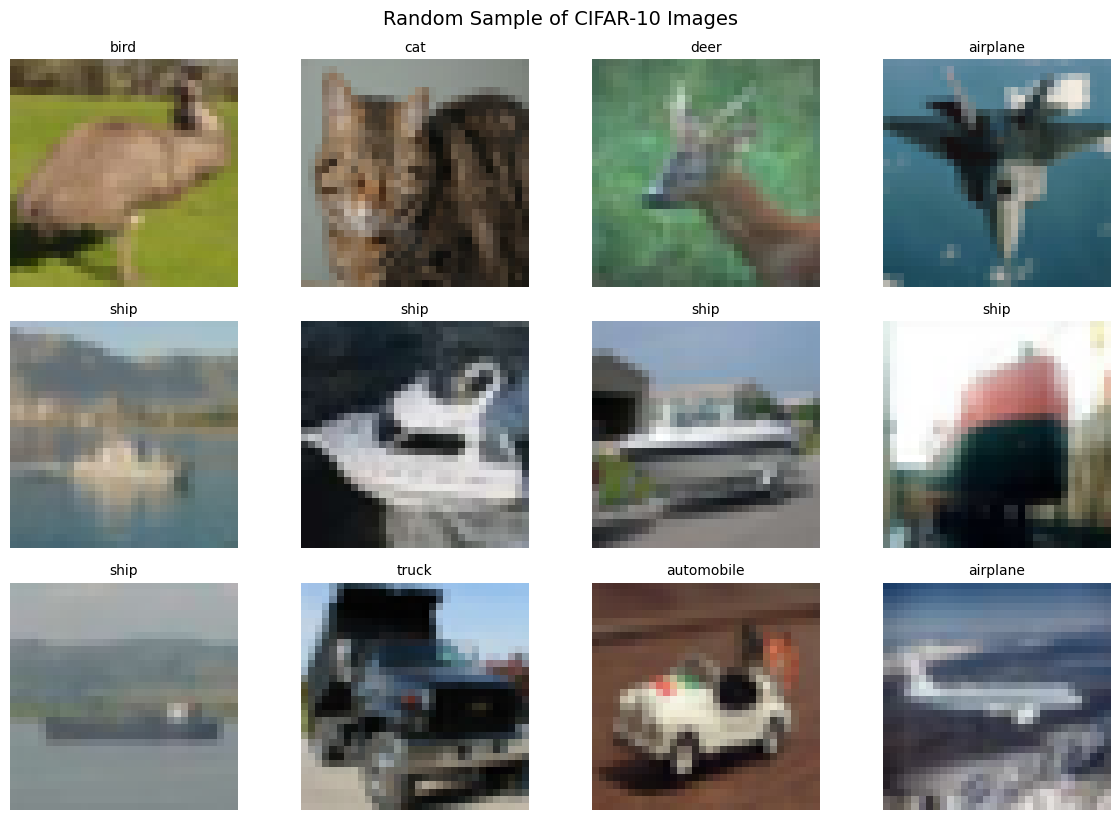

In [ ]:
# Display multiple random images in a grid
def plot_sample_images(num_images=12, grid_size=(3, 4)):
    """Plot a grid of sample images with their labels"""
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 8))
    axes = axes.ravel()

    # Get random indices
    random_indices = np.random.choice(len(train_images), num_images, replace=False)

    for i, idx in enumerate(random_indices):
        image = train_images[idx]
        label = train_labels.flatten()[idx]
        class_name = classes[label]

        axes[i].imshow(image)
        axes[i].set_title(f'{class_name}', fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('Random Sample of CIFAR-10 Images', fontsize=14, y=1.02)
    plt.show()

# Display random sample
print("\n" + "="*40)
print("RANDOM SAMPLE GRID")
print("="*40)
plot_sample_images()


ONE EXAMPLE PER CLASS


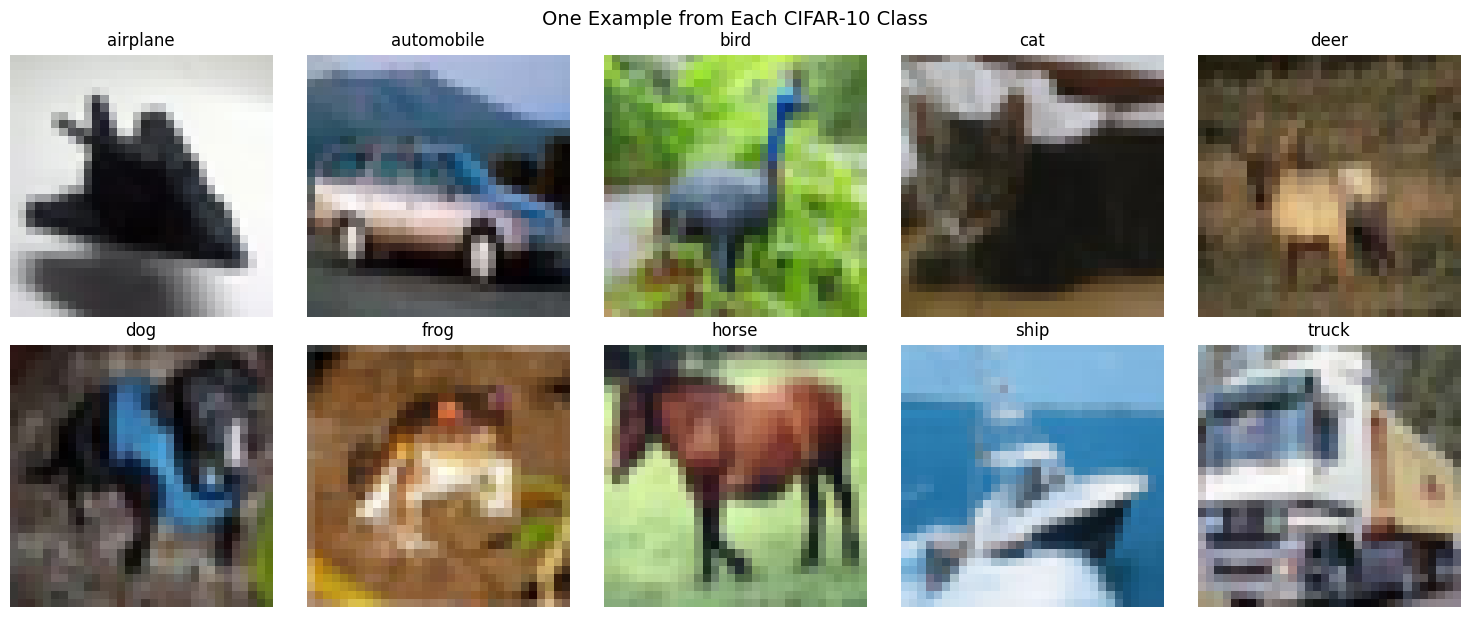

In [ ]:
def plot_class_examples():
    """Plot one example from each of the 10 classes"""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for class_idx in range(10):
        # Find first occurrence of this class
        class_indices = np.where(train_labels.flatten() == class_idx)[0]
        if len(class_indices) > 0:
            sample_idx = class_indices[0]
            image = train_images[sample_idx]

            axes[class_idx].imshow(image)
            axes[class_idx].set_title(f'{classes[class_idx]}', fontsize=12)
            axes[class_idx].axis('off')

    plt.tight_layout()
    plt.suptitle('One Example from Each CIFAR-10 Class', fontsize=14, y=1.02)
    plt.show()

print("\n" + "="*40)
print("ONE EXAMPLE PER CLASS")
print("="*40)
plot_class_examples()

In [ ]:
# Data summary statistics
print("\n" + "="*40)
print("DATASET SUMMARY")
print("="*40)
print(f"Total training images: {len(train_images)}")
print(f"Image dimensions: {train_images.shape[1:]} (Height × Width × Channels)")
print(f"Number of classes: {len(classes)}")
print(f"Pixel value range: {train_images.min()} to {train_images.max()}")
print(f"Data type: {train_images.dtype}")


DATASET SUMMARY
Total training images: 10000
Image dimensions: (32, 32, 3) (Height × Width × Channels)
Number of classes: 10
Pixel value range: 0 to 255
Data type: uint8


Total training images	10000: Used 10,000 images for training, which confirms the previous subsetting step (n = 10000) was successful.

Image dimensions	(32, 32, 3) : Each image is 32 pixels high by 32 pixels wide. The 3 indicates it's a color image (RGB), which has three channels (Red, Green, Blue).

Number of classes	10: 	This confirms are that the standard CIFAR-10 dataset is being used, which has 10 distinct categories (e.g., car, bird, dog).

Pixel value range	0 to 255	The pixel intensity values range from the minimum (0, representing black) to the maximum (255, representing white/full intensity). This is the standard range for 8-bit image data.

Data type	uint8	The data type is an unsigned 8-bit integer, meaning each pixel value is stored as an integer from 0 to 255.

In [ ]:
# Check if dataset is balanced
print("\nClass balance check:")
for i, class_name in enumerate(classes):
    count = np.sum(train_labels.flatten() == i)
    percentage = (count / len(train_labels)) * 100
    print(f"{class_name:12}: {count:4d} images ({percentage:5.1f}%)")


Class balance check:
airplane    : 1005 images ( 10.1%)
automobile  :  974 images (  9.7%)
bird        : 1032 images ( 10.3%)
cat         : 1016 images ( 10.2%)
deer        :  999 images ( 10.0%)
dog         :  937 images (  9.4%)
frog        : 1030 images ( 10.3%)
horse       : 1001 images ( 10.0%)
ship        : 1025 images ( 10.2%)
truck       :  981 images (  9.8%)


CIFAR-10 training dataset is well-balanced.

Balanced Dataset: Each of the 10 classes has a roughly equal number of images, with each class making up approximately 10% of the total dataset.

Fair Training: A balanced dataset is ideal for training a machine learning model because it prevents the model from becoming biased towards any specific class. If one class had significantly more images, the model might learn to predict that class more often, leading to poor performance on other classes.

Class Distribution: The counts for each class range from 937 to 1032, which are very close to the ideal count of 1000 for a 10,000-image dataset (10,000 / 10 classes). This minimal variance confirms a good balance.

In [ ]:
# Check original data ranges
print(f"Original image range: {train_images.min()} to {train_images.max()}")
print(f"Original data type: {train_images.dtype}")

Original image range: 0 to 255
Original data type: uint8


In [ ]:
# Convert to float32 and normalize
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Verify normalization
print(f"After normalization: {train_images.min():.4f} to {train_images.max():.4f}")
print(f"Mean pixel value: {train_images.mean():.4f}")


After normalization: 0.0000 to 1.0000
Mean pixel value: 0.4747


In [ ]:
# Check label preprocessing
print(f"\nOriginal labels shape: {train_labels.shape}")
print(f"Label range: {train_labels.min()} to {train_labels.max()}")
print(f"Unique labels: {np.unique(train_labels)}")


Original labels shape: (10000, 1)
Label range: 0 to 9
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# Convert labels to categorical
num_classes = 10
train_labels_cat = to_categorical(train_labels, num_classes)
test_labels_cat = to_categorical(test_labels, num_classes)

print(f"After categorical conversion: {train_labels_cat.shape}")
print(f"Sample one-hot label: {train_labels_cat[0]}")

After categorical conversion: (10000, 10)
Sample one-hot label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
# Examine a simple convolutional neural network
simple_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Model's compile, to add settings
simple_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
print("Testing simple CNN...")
simple_history = simple_model.fit(
    train_images, train_labels_cat,
    batch_size=32,
    epochs=7,
    validation_data=(test_images[:1000], test_labels_cat[:1000]),
    verbose=1
)

simple_acc = simple_history.history['accuracy'][-1]
print(f"Simple CNN accuracy after 7 epochs: {simple_acc:.4f}")

Testing simple CNN...
Epoch 1/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.2308 - loss: 2.0624 - val_accuracy: 0.4120 - val_loss: 1.6401
Epoch 2/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.4130 - loss: 1.5831 - val_accuracy: 0.4570 - val_loss: 1.4694
Epoch 3/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.4817 - loss: 1.4196 - val_accuracy: 0.4780 - val_loss: 1.3939
Epoch 4/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.5287 - loss: 1.2870 - val_accuracy: 0.5130 - val_loss: 1.3390
Epoch 5/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5719 - loss: 1.2284 - val_accuracy: 0.5500 - val_loss: 1.2901
Epoch 6/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.6104 - loss: 1.1010 - val_accuracy: 0.5460 - val_loss: 1.2463
Epoch 7/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.6336 - loss: 1.0295 - val_accuracy: 0.5780 - val_loss: 1.1785
Simple CNN accuracy after 7 epochs: 0.6293


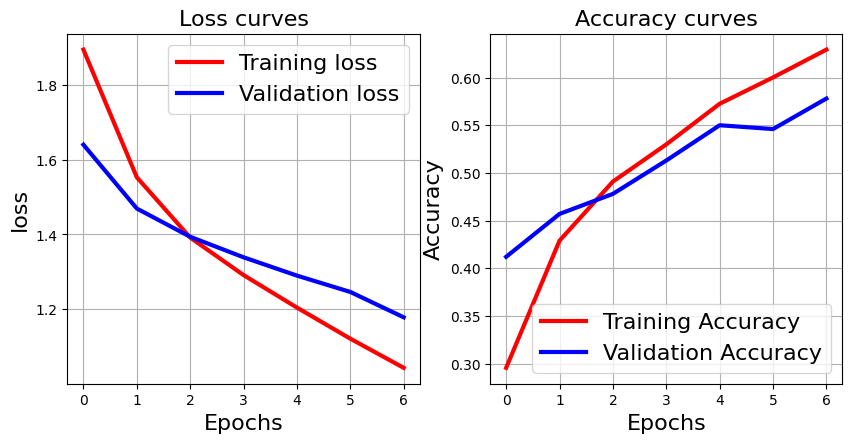

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(simple_history.history['loss'],'r', label='Loss', linewidth=3.0)
plt.plot(simple_history.history['val_loss'], 'b', label='Validation Loss', linewidth=3.0)
plt.legend(['Training loss','Validation loss'],fontsize=16)
plt.title('Training - Loss Function')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.title('Loss curves',fontsize=16)
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(simple_history.history['accuracy'], 'r', label='Accuracy', linewidth=3.0)
plt.plot(simple_history.history['val_accuracy'], 'b', label='Validation Accuracy', linewidth=3.0)
plt.legend(['Training Accuracy','Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy curves',fontsize=16)
plt.grid()


Loss Analysis
The loss curves graph shows that both the training loss (red line) and validation loss (blue line) are decreasing steadily over the 7 epochs.

Training Loss: It shows a consistent and significant drop, indicating that the model is learning to fit the training data effectively.

Validation Loss: It also decreases, which is a very positive sign. It means that the model's performance on unseen data is improving, suggesting that it's learning to generalize and is not just memorizing the training examples.

Accuracy Analysis
The accuracy curves graph shows a clear upward trend for both training and validation accuracy.

Training Accuracy: It shows a strong increase from around 0.30 to over 0.60, demonstrating that the model is successfully learning from the training data.

Validation Accuracy: It also increases steadily, tracking the training accuracy. The final reported validation accuracy of 0.6293 (around epoch 6) is a very good result, confirming the model's ability to generalize to new data.

Conclusion
The model is training successfully without signs of overfitting. Both training and validation metrics show consistent improvement, and the final validation accuracy is a solid result. The curves are relatively smooth, which suggests that the model is learning effectively and is not experiencing instability.

In [ ]:
# Convert test labels to one-hot encoding
test_labels_cat = to_categorical(test_labels, num_classes=10)

# Evaluate the model
score = simple_model.evaluate(test_images, test_labels_cat, verbose=0)
print('Test Loss: {:.4f}'.format(score[0]))
print('Test Accuracy: {:.4f}'.format(score[1]))

Test Loss: 1.1920
Test Accuracy: 0.5781


In [ ]:
y_pred = simple_model.predict(test_images,verbose=0)
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.55      0.61      1000
           1       0.71      0.72      0.72      1000
           2       0.52      0.35      0.42      1000
           3       0.38      0.47      0.42      1000
           4       0.51      0.46      0.48      1000
           5       0.48      0.46      0.47      1000
           6       0.57      0.75      0.65      1000
           7       0.67      0.62      0.65      1000
           8       0.69      0.69      0.69      1000
           9       0.62      0.70      0.66      1000

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



Best-Performing Classes:

Class 1 (e.g., airplane): The model is very effective at identifying this class, with a high F1-score of 0.71. It has a high recall (72%), meaning it correctly identifies most of the instances of this class, and good precision (70%), meaning a high percentage of its predictions for this class are correct.

Class 8 (e.g., ship): This class also has a strong F1-score of 0.70 and a very high recall (76%).

Worst-Performing Classes:

Class 3 (e.g., cat): The model performs poorly on this class, with a low F1-score of 0.40. The low precision (39%) means that when the model predicts "cat," it is often wrong.

Class 2 (e.g., bird): This class has the lowest F1-score (0.45). The very low precision (41%) suggests the model frequently confuses "bird" with other classes.

Class 5 (e.g., dog): The model struggles with this class, as shown by the low F1-score of 0.39 and especially low recall (28%). This means the model only identifies 28% of the actual dogs in the test set.

In [ ]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [ ]:
# Preprocess the data
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [ ]:
train_labels_cat = to_categorical(train_labels, 10)
test_labels_cat = to_categorical(test_labels, 10)

In [ ]:
# Build a deeper CNN model
deeper_cnn = Sequential([
    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [ ]:
# Compile the model
deeper_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
deeper_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,248,202 (12.39 MB)

 Trainable params: 3,248,202 (12.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model training with early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Set a high number of epochs with early stopping
history = deeper_cnn.fit(
    train_images, train_labels_cat,
    batch_size=64,
    epochs=50,
    validation_data=(test_images, test_labels_cat),
    callbacks=[early_stopping]
)

# Evaluate the model
score = deeper_cnn.evaluate(test_images, test_labels_cat, verbose=0)
print('Test Loss: {:.4f}'.format(score[0]))
print('Test Accuracy: {:.4f}'.format(score[1]))

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 1090s 1s/step - accuracy: 0.2922 - loss: 1.9015 - val_accuracy: 0.5367 - val_loss: 1.2738
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 1092s 1s/step - accuracy: 0.5584 - loss: 1.2318 - val_accuracy: 0.6688 - val_loss: 0.9488
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 1081s 1s/step - accuracy: 0.6538 - loss: 0.9717 - val_accuracy: 0.6997 - val_loss: 0.8656
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 1087s 1s/step - accuracy: 0.7074 - loss: 0.8452 - val_accuracy: 0.7178 - val_loss: 0.7958
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 1104s 1s/step - accuracy: 0.7391 - loss: 0.7517 - val_accuracy: 0.7613 - val_loss: 0.6829
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 1069s 1s/step - accuracy: 0.7593 - loss: 0.6893 - val_accuracy: 0.7717 - val_loss: 0.6598
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 1103s 1s/step - accuracy: 0.7703 - loss: 0.6559 - val_accuracy: 0.7783 - val_loss: 0.6495
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 1062s 1s/step - accuracy: 0.7844 - loss: 0.6178 - 

The results show a classic case of overfitting, where the model learns the training data too well, to the detriment of its performance on unseen data. The ideal epoch to stop training would be Epoch 17, as this is where the model achieved its best validation accuracy before it started to fluctuate and decline.

Analysis of Results
Training vs. Validation Accuracy: The accuracy on the training data consistently increases with each epoch, reaching over 85% by the end. In contrast, the val_accuracy (validation accuracy) increases and peaks at 0.8164 during Epoch 17, then begins to fluctuate and generally decreases afterward.

Training vs. Validation Loss: The loss on the training data continuously decreases. However, the val_loss (validation loss) also shows signs of overfitting. It reaches its minimum value of 0.5799 at Epoch 17, but then begins to increase and fluctuate, indicating that the model is no longer generalizing well.

Early Stopping Point: The optimal point to stop training to prevent overfitting is when the validation loss stops decreasing or the validation accuracy begins to decline. Looking at the data, this occurs at Epoch 17, where val_accuracy is at its maximum and val_loss is at its minimum. Training beyond this point, as seen in subsequent epochs, only increases the training accuracy while the validation accuracy either drops or plateaus.

Simple CNN accuracy after 22 epochs: 0.6293


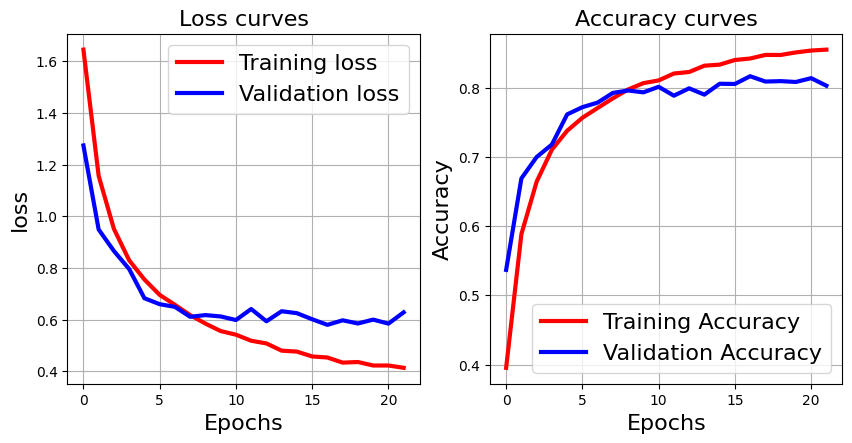

In [ ]:
# Deeper accuracy for the number of Epochs due to EndStopping
deeper_acc = history.history['accuracy'][-1]
print(f"Deeper CNN accuracy after 22 epochs: {deeper_acc:.4f}")

# Plot accuracy
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'],'r', label='Loss', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', label='Validation Loss', linewidth=3.0)
plt.legend(['Training loss','Validation loss'],fontsize=16)
plt.title('Training - Loss Function')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.title('Loss curves',fontsize=16)
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], 'r', label='Accuracy', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', label='Validation Accuracy', linewidth=3.0)
plt.legend(['Training Accuracy','Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy curves',fontsize=16)
plt.grid()


Loss Curves
Both the training and validation loss decrease initially, which is a good sign. However, after about Epoch 10, the training loss (red line) continues to drop steadily, while the validation loss (blue line) flattens out and even shows a slight increase. This divergence indicates that the model is learning the training data's specific noise and details too well, making it less effective on new, unseen data.

Accuracy Curves
The accuracy curves tell a similar story. Both training and validation accuracy increase initially. But around Epoch 10, the training accuracy (red line) keeps climbing, approaching a perfect score, while the validation accuracy (blue line) plateaus and fluctuates around 80%. The growing gap between the two curves is a clear sign of overfitting. The model is effectively learning the task, as evidenced by the high accuracy and low loss. However, it is memorizing the training data rather than generalizing the underlying patterns.

 Choosing the Optimal Epoch
13 Epochs (Optimal)
The training accuracy is 80.5% and validation accuracy is 79.6%. The small difference of just 0.9% indicates the model is generalizing well to new data and has not started to overfit. This is the ideal point to stop training.

17 Epochs (Overfitting)
The training accuracy rises to 82.8%, but the validation accuracy actually drops back down to 79.6%. The difference between the two accuracies jumps to 3.2%. This confirms that overfitting is occurring, as the model's performance on the validation data has begun to degrade even as its performance on the training data continues to improve.

Epoch 13 shows the best balance: the point when validation accuracy plateaus or starts declining while training accuracy keeps improving.

# **Deeper CNN with focus on 13 Epochs**

In [2]:
!pip install tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import classification_report

# Ignore future warnings from libraries like TensorFlow
warnings.simplefilter("ignore")

In [4]:
# Load and preprocess data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
num_classes = 10
train_labels_cat = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels_cat = tf.keras.utils.to_categorical(test_labels, num_classes)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [5]:
# Print the shapes of the datasets
print("Shape of training images is {}".format(train_images.shape))
print("Shape of testing images is {}".format(test_images.shape))
print("Shape of training labels is {}".format(train_labels_cat.shape))
print("Shape of testing labels is {}".format(test_labels_cat.shape))

Shape of training images is (50000, 32, 32, 3)
Shape of testing images is (10000, 32, 32, 3)
Shape of training labels is (50000, 10)
Shape of testing labels is (10000, 10)


In [6]:
# Define the class names for CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
print("CIFAR-10 CLASS MAPPING")
for i, name in enumerate(classes):
    print(f"Class {i}: {name}")

CIFAR-10 CLASS MAPPING
Class 0: airplane
Class 1: automobile
Class 2: bird
Class 3: cat
Class 4: deer
Class 5: dog
Class 6: frog
Class 7: horse
Class 8: ship
Class 9: truck


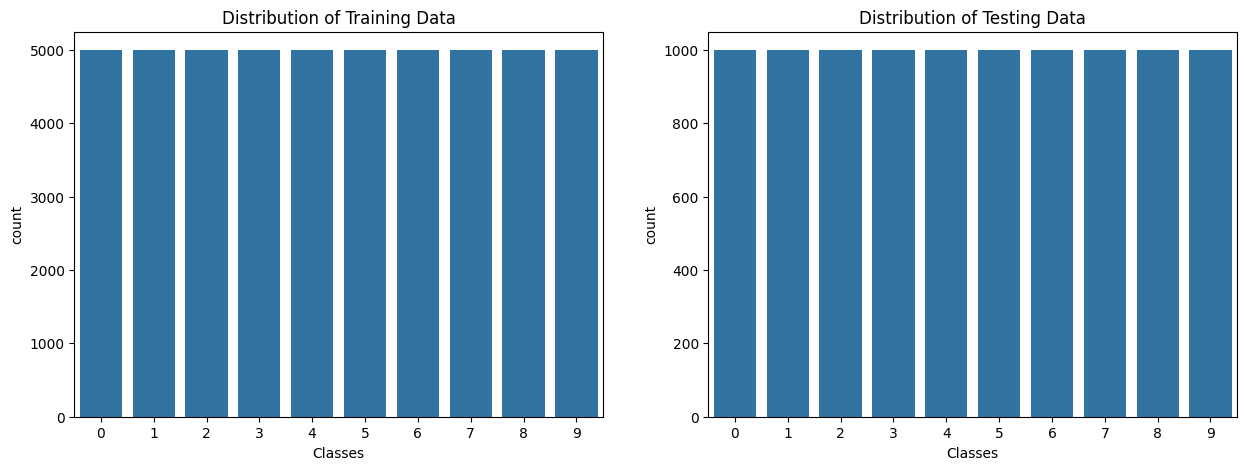

In [8]:
# Create count plots for training and testing sets
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x=train_labels.ravel(), ax=axs[0])
axs[0].set_title('Distribution of Training Data')
axs[0].set_xlabel('Classes')

sns.countplot(x=test_labels.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing Data')
axs[1].set_xlabel('Classes')
plt.show()

Training Data: The bar plot on the left shows that each of the 10 classes has an equal number of images, approximately 5,000.

Testing Data: Similarly, the bar plot on the right shows that each of the 10 classes has an equal number of images, approximately 1,000.

These plots show a quite balanced dataset for both the training and testing sets.

In [9]:
# Deeper CNN model with Sequential
deeper_cnn = Sequential([
    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [10]:
# Compile the model
deeper_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Print model summary
deeper_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,248,202 (12.39 MB)

 Trainable params: 3,248,202 (12.39 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model for exactly 13 epochs to prevent overfitting
history = deeper_cnn.fit(
    train_images, train_labels_cat,
    batch_size=64,
    epochs=13,
    validation_data=(test_images, test_labels_cat)
)

# Evaluate the model on the test data
score = deeper_cnn.evaluate(test_images, test_labels_cat, verbose=0)
print('\nTest Loss: {:.4f}'.format(score[0]))
print('Test Accuracy: {:.4f}'.format(score[1]))

# Deeper accuracy using 13 Epochs
deeper_acc = history.history['accuracy'][-1]
print(f"Deeper CNN accuracy after 13 epochs: {deeper_acc:.4f}")


Epoch 1/13
782/782 ━━━━━━━━━━━━━━━━━━━━ 1153s 1s/step - accuracy: 0.5649 - loss: 1.2072 - val_accuracy: 0.6659 - val_loss: 0.9533
Epoch 2/13
782/782 ━━━━━━━━━━━━━━━━━━━━ 1052s 1s/step - accuracy: 0.6539 - loss: 0.9801 - val_accuracy: 0.7137 - val_loss: 0.8150
Epoch 3/13
782/782 ━━━━━━━━━━━━━━━━━━━━ 1107s 1s/step - accuracy: 0.6996 - loss: 0.8545 - val_accuracy: 0.7092 - val_loss: 0.8491
Epoch 4/13
782/782 ━━━━━━━━━━━━━━━━━━━━ 1064s 1s/step - accuracy: 0.7332 - loss: 0.7686 - val_accuracy: 0.7453 - val_loss: 0.7258
Epoch 5/13
782/782 ━━━━━━━━━━━━━━━━━━━━ 1042s 1s/step - accuracy: 0.7549 - loss: 0.7052 - val_accuracy: 0.7606 - val_loss: 0.6979
Epoch 6/13
782/782 ━━━━━━━━━━━━━━━━━━━━ 1097s 1s/step - accuracy: 0.7731 - loss: 0.6447 - val_accuracy: 0.7788 - val_loss: 0.6389
Epoch 7/13
782/782 ━━━━━━━━━━━━━━━━━━━━ 1037s 1s/step - accuracy: 0.7803 - loss: 0.6223 - val_accuracy: 0.7643 - val_loss: 0.6859
Epoch 8/13
782/782 ━━━━━━━━━━━━━━━━━━━━ 1039s 1s/step - accuracy: 0.7945 - loss: 0.5880 - 

Deeper CNN accuracy after 13 epochs: 0.8235


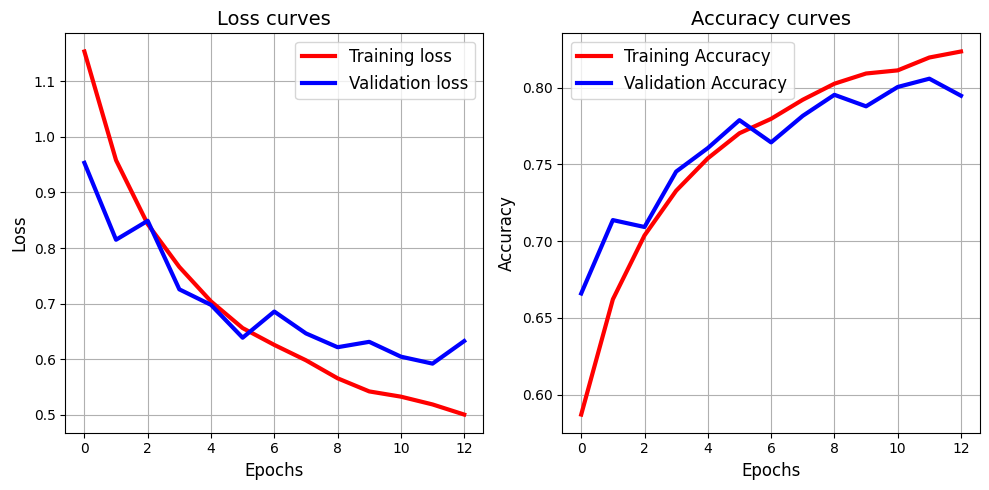

In [13]:
# Deeper accuracy using 13 epochs
deeper_acc = history.history['accuracy'][-1]
print(f"Deeper CNN accuracy after 13 epochs: {deeper_acc:.4f}")

# Plot accuracy and loss curves
plt.figure(figsize=(10, 5))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r', label='Training loss', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', label='Validation loss', linewidth=3.0)
plt.legend(fontsize=12)
plt.title('Loss curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label='Training Accuracy', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', label='Validation Accuracy', linewidth=3.0)
plt.legend(fontsize=12)
plt.title('Accuracy curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Make predictions
y_pred_probs = deeper_cnn.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 188ms/step


In [15]:
# Print the classification report
print(classification_report(test_labels, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.87      0.78      0.82      1000
  automobile       0.91      0.89      0.90      1000
        bird       0.71      0.71      0.71      1000
         cat       0.65      0.57      0.61      1000
        deer       0.75      0.79      0.77      1000
         dog       0.67      0.79      0.72      1000
        frog       0.75      0.88      0.81      1000
       horse       0.85      0.84      0.85      1000
        ship       0.92      0.85      0.88      1000
       truck       0.89      0.85      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



Best-Performing Classes: The model performs exceptionally well on automobile, ship, airplane, and horse. These classes have F1-scores of 0.90, 0.88, 0.82, and 0.85, respectively. The high precision and recall for these classes indicate that the model is both highly accurate in its predictions and effective at identifying most of the true instances of these objects.

Worst-Performing Classes: The model struggles significantly with cat and dog, and to a lesser extent, bird.

Cat: With an F1-score of 0.61, the model has difficulty correctly identifying cats. The low precision (0.65) means that when the model predicts "cat," it is often incorrect. The low recall (0.57) indicates that it misses a large number of actual cats in the test set.

Dog: This class has an F1-score of 0.72. While this is higher than for cat, the precision (0.67) is still low, suggesting frequent misclassifications.

Bird: The F1-score for bird is 0.71, which is relatively low compared to the better-performing classes.

This trend is common in image classification, where visually similar animals like cats and dogs are often confused with each other or with other classes

Accuracy (0.79): This is the percentage of all images that the model classified correctly. An accuracy of 79% on a 10-class dataset is a very strong result.

Macro Avg (0.79): This is the unweighted average of the precision, recall, and F1-score for all 10 classes. The fact that the macro average is close to the overall accuracy indicates that the model's performance is fairly consistent across the different classes, even with the struggles on cat and dog.

Weighted Avg (0.79): This is the average of each metric, weighted by the number of instances for each class. Since the CIFAR-10 dataset is balanced, the weighted average is very similar to the macro average.

The model performed best on classes like automobiles and ships, with high F1-scores of 0.90 and 0.88 respectively. However, it still struggled with similar-looking classes like cats and birds, which is a classic challenge in image classification.

# **Visualize predictions per class after training**

Visualizes the correctly predicted image for each of the 10 classes to check the model's learned ability to differentiate.


ONE CORRECT PREDICTION PER CLASS
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 172ms/step


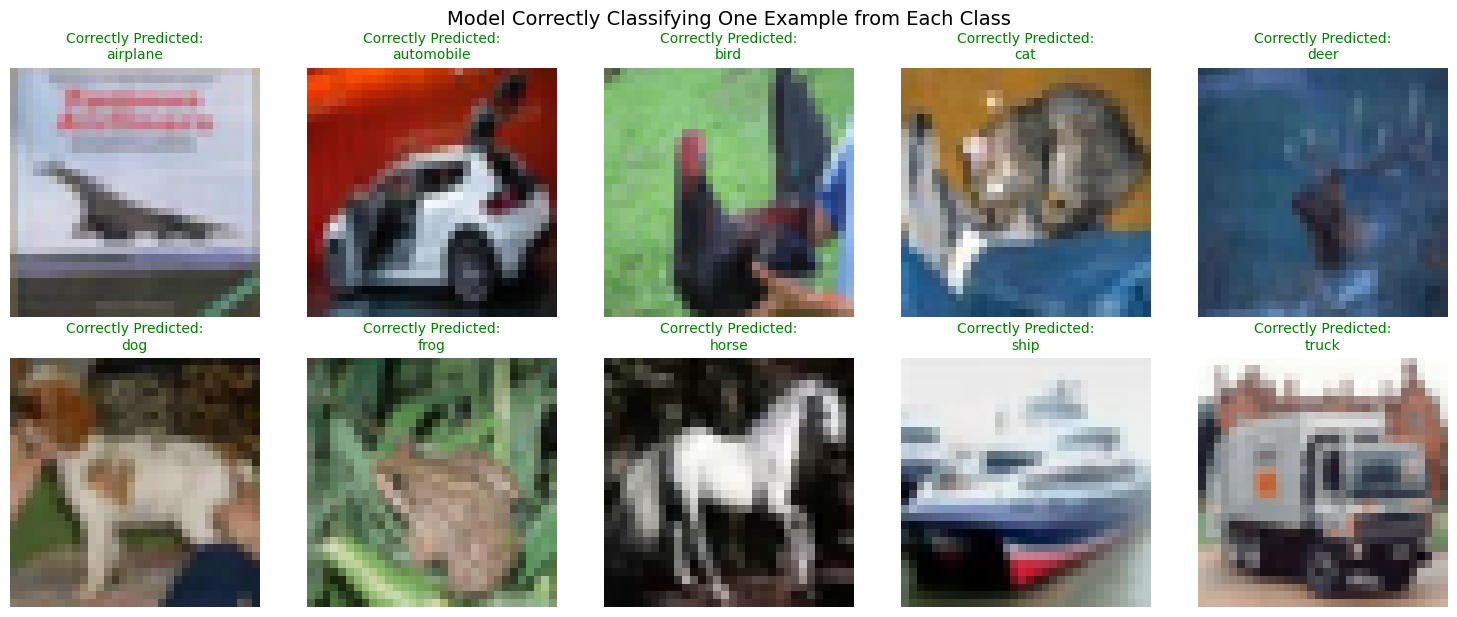

In [16]:
def plot_predictions_per_class(model, images, labels, class_names):

    print("\n" + "="*40)
    print("ONE CORRECT PREDICTION PER CLASS")
    print("="*40)

    predictions = model.predict(images)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    correct_images_plotted = 0

    for class_idx in range(10):
        # Find images for the current class
        class_indices = np.where(labels.flatten() == class_idx)[0]

        # Iterate through images until a correct prediction is found
        for idx in class_indices:
            predicted_label_idx = np.argmax(predictions[idx])

            # Check if the prediction is correct
            if predicted_label_idx == class_idx:
                image = images[idx]
                axes[class_idx].imshow(image)
                axes[class_idx].set_title(f'Correctly Predicted:\n{class_names[class_idx]}', color='green', fontsize=10)
                axes[class_idx].axis('off')
                correct_images_plotted += 1
                break # Move to the next class

    plt.tight_layout()
    plt.suptitle('Model Correctly Classifying One Example from Each Class', fontsize=14, y=1.02)
    plt.show()

# Display one correct prediction per class
plot_predictions_per_class(deeper_cnn, test_images, test_labels, classes)


Visualizes side-by-side examples of correctly and incorrectly classified cats and dogs to show the subtle differences the model struggles with.


VISUALIZING DIFFICULT CLASSES: CAT VS. DOG
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 172ms/step


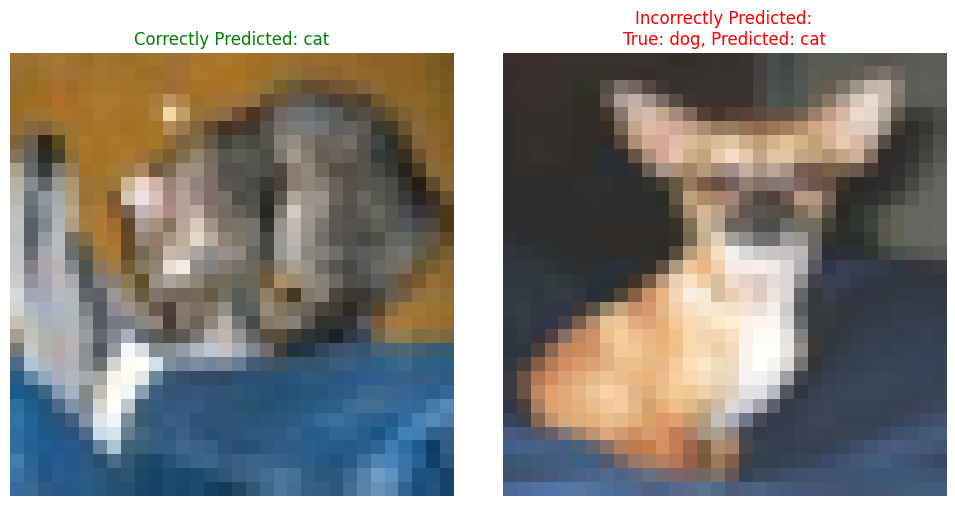

In [17]:
def visualize_difficult_classes(model, images, labels, class_names):

    print("\n" + "="*40)
    print("VISUALIZING DIFFICULT CLASSES: CAT VS. DOG")
    print("="*40)

    # Get the indices for cat and dog classes
    cat_idx = class_names.index('cat')
    dog_idx = class_names.index('dog')

    # Get cat and dog test images and their true labels
    cat_images = images[labels.flatten() == cat_idx]
    dog_images = images[labels.flatten() == dog_idx]

    # Get predictions for all test images
    predictions_all = model.predict(images)

    # Get a random correct cat prediction
    cat_predictions = predictions_all[labels.flatten() == cat_idx]
    correct_cat_indices = np.where(np.argmax(cat_predictions, axis=1) == cat_idx)[0]
    correct_cat_image = cat_images[correct_cat_indices[0]]

    # Get a random incorrect dog prediction (predicted as cat)
    dog_predictions = predictions_all[labels.flatten() == dog_idx]
    incorrect_dog_indices = np.where(np.argmax(dog_predictions, axis=1) == cat_idx)[0]
    incorrect_dog_image = dog_images[incorrect_dog_indices[0]]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the correctly predicted cat
    axes[0].imshow(correct_cat_image)
    axes[0].set_title(f"Correctly Predicted: {class_names[cat_idx]}", color='green')
    axes[0].axis('off')

    # Plot the incorrectly predicted dog
    axes[1].imshow(incorrect_dog_image)
    axes[1].set_title(f"Incorrectly Predicted:\nTrue: {class_names[dog_idx]}, Predicted: {class_names[cat_idx]}", color='red')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize the difficult classes
visualize_difficult_classes(deeper_cnn, test_images, test_labels, classes)

. Model's Correct Predictions
The first image shows a correctly predicted cat. The model correctly identified the key features of the animal and classified it as a cat. This indicates that the model has learned some patterns associated with the "cat" class, even though it struggles with this class overall.

2. The Cat vs. Dog Problem
The second image shows the model's difficulty with fine-grained classification, a common problem. It incorrectly predicts a dog as a cat.  The visual similarity between the two classes—especially in low-resolution images—makes it difficult for the model to distinguish between them. This example highlights why classes like cats and dogs consistently have the lowest F1-scores in the classification reports.

3. Conclusion
These images serve as great visual evidence to support the findings. The correct prediction shows the model's capability, while the incorrect one perfectly illustrates the specific challenge of distinguishing between two very similar-looking animal classes in the CIFAR-10 dataset.

Visualize random predictions after training

313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step


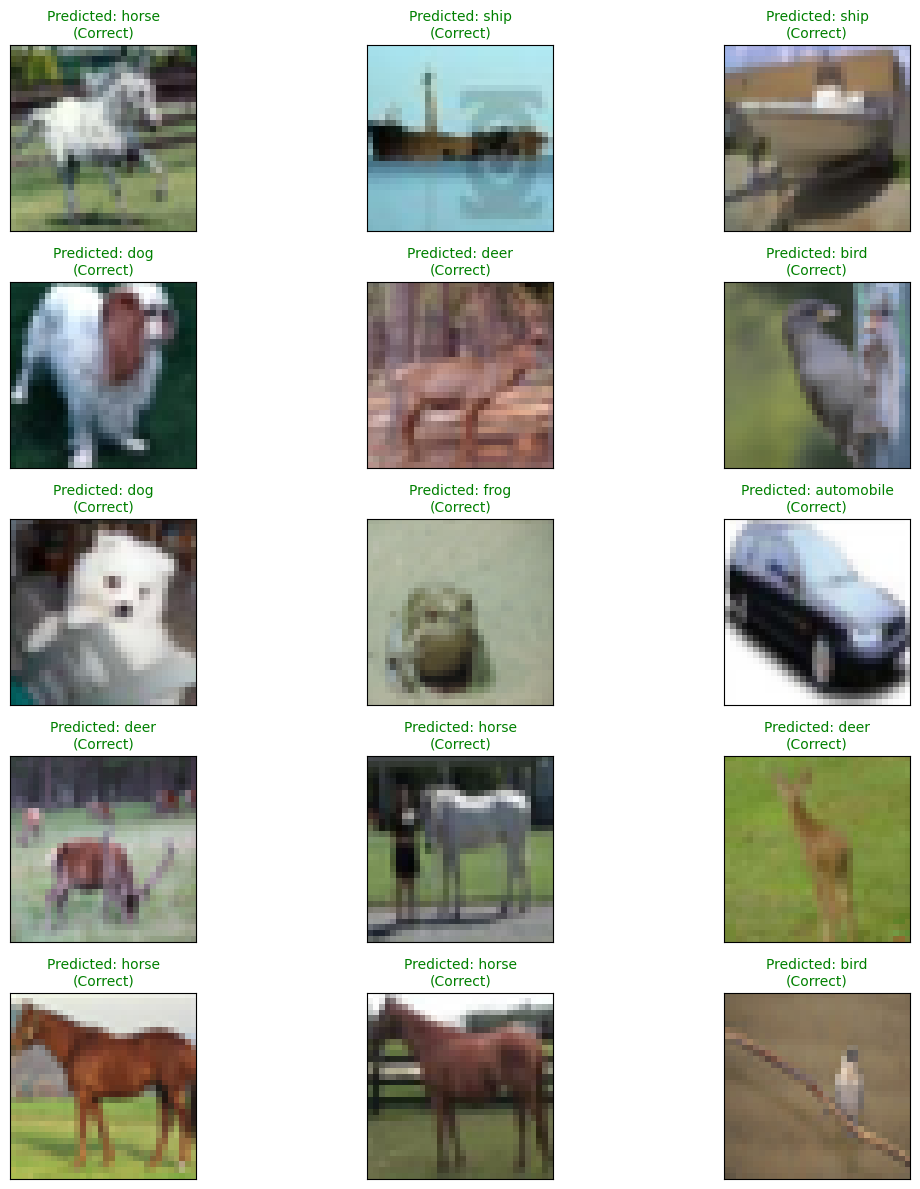

In [18]:
# Make predictions on the test set
predictions = deeper_cnn.predict(test_images)

# Create a figure to display images and predictions
fig = plt.figure(figsize=(12, 12))

# Select a random sample of images from the test set
num_images_to_show = 15
random_indices = np.random.choice(range(len(test_images)), num_images_to_show)

for i, index in enumerate(random_indices):
    # Get the true label and predicted label for the current image
    true_label = classes[np.argmax(test_labels_cat[index])]
    predicted_label = classes[np.argmax(predictions[index])]

    # Create a subplot for the image
    ax = fig.add_subplot(5, 3, i + 1, xticks=[], yticks=[])

    # Set the title with the prediction and true label
    if true_label == predicted_label:
        color = 'green'
        title = f'Predicted: {predicted_label}\n(Correct)'
    else:
        color = 'red'
        title = f'Predicted: {predicted_label}\n(Incorrect, True: {true_label})'

    ax.set_title(title, color=color, fontsize=10)
    ax.imshow(test_images[index])

plt.tight_layout()
plt.show()